#### Соколова Ирина 23/10/2020

### RFM-анализ Тестовое задание


Представьте, что перед командой Яндекс.Маркета стоит задача по увеличению LTV за счет уменьшения оттока пользователей и увеличения частоты контакта. К вам приходит менеджер и просит провести исследование и ответить на вопрос, каким способом можно достичь указанной цели.

Вам необходимо сделать RFM-анализ и подготовить рекомендации команде сервиса. Предложите хотя бы один проект по увеличению LTV и оцените потенциальную пользу от этого проекта. Рекомендации по увеличению монетизируемости без увеличения частоты контакта так же приветствуются.

В приложенном файле ( https://drive.google.com/file/d/0B1to5U2MbtNcVzg1OUlmUXpDNTA/view ) собраны данные об активности пользователей основного сайта Яндекс.Маркета.

Поля: 
timestamp хита 
user_id 
url - url хита или "click", если пользователь перешел в интернет-магазин 
geo_id - идентификатор региона пользователя 
category - идентификатор категории 
price - стоимость клика, если пользователь перешел в интернет-магазин

Результаты анализа оформите, пожалуйста, в виде презентации и рассказа команде о результатах.

Важный момент, для первичной обработки данных необходимо использовать именно Python (не R) и приложить получившиеся скрипты.


### План:

Для анализа я выделю только клиентов, то есть тех пользователей price > 0.
Посмотрю на географию наших клиентов.

Большую долю составлю клиенты Москвы и Санкт-Петербурга, можно предположить, что поведение этих клиентов будет отличаться от поведения клиентов из регионов. Доступность быстрой доставки, например может быть причиной по которой пользователям из этих регионом проще сделать заказ через интернет. С другой стороны региональные клиенты могут более тщательно выбирать интернет магазин в котором они закажут свой товар. Поиск удобного магазина повышает кликабельнось сервиса и как следствие увеличивает LTV.

Задача маркетплейса - удовлетворить запрос потребителя, важно, чтобы покупатель не только нашел свой товар, но и купил его по интересующей цене, а также выбрал удобный для него магазин.

Задача RFM анализа - разделить объективно всех покупателей на кластеры. Это метод персонализации клиентов. Создавая эффективные сегменты можно постороить доверительные отношения с покупателем.

Для кластреизации пользователей я рассчитаю RFM для каждого пользователя, затем использую алгоритм  KMeans, предварительно проверив на какое количество кластеров можно разделить пользователей. 
Данные могут содержать выбросы, поэтому они будут нормированы np.log

Далее рассчитаю  RFM-метрики для каждого кластера

В данных нет информации по затратам,  поэтому Monitory  и будет нашей LTV(life time value).
Также интересно будет ввести переменную Количество уникальных категорий по которым пользователь совершал  клики, она может характеризовать как пользователь вовлечен в работу сервиса, как часто он им пользуется. 

Churn rate - это метрика которая оценивает количество пользователей, которые покинули продукт в определенное время. Churn rate я буду анализировать через Retention, так как Retention, на мой взгляд более позитивна и является обратной метрикой. Задача сделать найти способы увеличить ретеншен и вовлеченность наших клиентов в сервис, что приведет к уменьшению Churn


### Импорт данных и характеристики данных

In [1]:
import tarfile
my_tar = tarfile.open('rfm.tar')
my_tar.extract('rfm.tsv','./Downloads')
my_tar.close()

In [2]:
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
import numpy as np
%matplotlib inline
from sklearn.cluster import KMeans

In [3]:
# категории
category = pd.read_csv('categories_tree.dms',sep='\t', engine='python')

In [4]:
category.head()

,id,parent_id,hyper_cat_id,category_name,category_pass
0,984,978,91768,Этикет-пистолеты,\tОборудование\tОборудование для магазинов\tЭт...
1,23187,978,10469630,Рекламные дисплеи и интерактивные панели,\tОборудование\tОборудование для магазинов\tРе...
2,10411,978,5057803,Манекены,\tОборудование\tОборудование для магазинов\tМа...
3,19545,978,6509282,Терминалы сбора данных,\tОборудование\tОборудование для магазинов\tТе...
4,981,978,91765,Весы,\tОборудование\tОборудование для магазинов\tВе...


In [5]:
# все типы данных нас устраивают
category.dtypes

id                int64
parent_id         int64
hyper_cat_id      int64
category_name    object
category_pass    object
dtype: object

In [6]:
# пустых значений нет
category.isna().sum()

id               0
parent_id        0
hyper_cat_id     0
category_name    0
category_pass    0
dtype: int64

In [7]:
#проверим по какому ID мы можем объединять данные
category[category.hyper_cat_id == 8476098]

,id,parent_id,hyper_cat_id,category_name,category_pass
1545,22368,22363,8476098,Снятие макияжа,"\tКрасота и здоровье\tКосметика, парфюмерия и ..."


In [8]:
# подготовим таблицу с необходимыми полями для дальнейшего объединения
cat_ = category[['hyper_cat_id','category_name', 'category_pass']].copy()
cat_.head()

,hyper_cat_id,category_name,category_pass
0,91768,Этикет-пистолеты,\tОборудование\tОборудование для магазинов\tЭт...
1,10469630,Рекламные дисплеи и интерактивные панели,\tОборудование\tОборудование для магазинов\tРе...
2,5057803,Манекены,\tОборудование\tОборудование для магазинов\tМа...
3,6509282,Терминалы сбора данных,\tОборудование\tОборудование для магазинов\tТе...
4,91765,Весы,\tОборудование\tОборудование для магазинов\tВе...


In [9]:
# Geo-данные
geo_table = pd.read_csv('geo_table.dms', sep='\t', engine='python')

In [10]:
geo_table.head()

,id,name,parent_region_id,type,TZ_OFFSET
0,1,Москва и Московская область,3.0,5,10800
1,2,Санкт-Петербург,10174.0,6,10800
2,3,Центральный федеральный округ,225.0,4,10800
3,4,Белгород,120914.0,6,10800
4,5,Иваново,120943.0,6,10800


In [11]:
geo_table.isna().sum()

id                  0
name                0
parent_region_id    1
type                0
TZ_OFFSET           0
dtype: int64

In [12]:
# переведем тип данных в int для дальнейшего объединения таблиц и заполним Nan
geo_table['parent_region_id'] = geo_table['parent_region_id'].fillna(103756.0).astype(int)

In [13]:
geo_table.dtypes

id                   int64
name                object
parent_region_id     int64
type                 int64
TZ_OFFSET            int64
dtype: object

In [14]:
# названия колонок для основного df
col_names = ['timestamp','user_id', 'url_click', 'geo_id', 'category', 'price']

In [15]:
# дата фрейм содрежащий информацию о пользователях
df = pd.read_csv('./Downloads/rfm.tsv',delim_whitespace=True,names=col_names, encoding = "ISO-8859-1", parse_dates = ['timestamp'],low_memory=False)

In [16]:
df.head()

,timestamp,user_id,url_click,geo_id,category,price
0,1380052543,00002ad98ae4290672431d702c211b4a,/_c/YwrVrj_29IVZDmKxglT53wo7Pk8.html,10000,NaN,NaN
1,1375703582,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=y5fc6079b758f5a4e3646a8...,10000,NaN,NaN
2,1374479873,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN
3,1374479892,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN
4,1374480337,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,NaN,NaN


In [17]:
df.dtypes

timestamp    object
user_id      object
url_click    object
geo_id       object
category     object
price        object
dtype: object

In [18]:
# датафрейм соделжит 10007147 записей
df.shape

(10007147, 6)

In [19]:
#добавим колонку date_time
df['date_time'] = pd.to_datetime(df['timestamp'], unit = 's')

In [20]:
#проверим количество None values
#практичеси половина данных не содержить информации о категориях
#10007147-9643817 = 363330 записей содержит информацию price
df.isna().sum()

timestamp          0
user_id            0
url_click          0
geo_id             0
category     4471181
price        9643817
date_time          0
dtype: int64

In [21]:
10007147-9643817

363330

In [22]:
#проверим совпадает ли эта цифра с выбокрой url_click == 'click'
df.query("url_click == 'click'")['price'].count()

363313

In [23]:
#самые распространенные регионы
df['geo_id'].value_counts().head()

10000    6096930
213      1832139
2         296505
54         91318
47         89190
Name: geo_id, dtype: int64

In [25]:
#самые популярные регионы 
print(geo_table[geo_table['id'] == 10000]['name'].values)
print(geo_table[geo_table['id'] == 213]['name'].values)
print (geo_table[geo_table['id'] == 2]['name'].values)
print (geo_table[geo_table['id'] == 54]['name'].values)
print (geo_table[geo_table['id'] == 47]['name'].values)


['Земля']
['Москва']
['Санкт-Петербург']
['Екатеринбург']
['Нижний Новгород']


In [26]:
geo = geo_table[['id', 'name']].copy()
geo.head()

,id,name
0,1,Москва и Московская область
1,2,Санкт-Петербург
2,3,Центральный федеральный округ
3,4,Белгород
4,5,Иваново


In [27]:
#меняем тип данных, заполняем наиболее популярным регионом NaN, пусть будет 'Земля'
df['geo_id'] = pd.to_numeric(df['geo_id'],errors='coerce').fillna(10000.0).astype(int)

In [28]:
#некоторые категории распарсились неправильно
df['category'].value_counts().tail(5)

91491#Kp79z9avo95           1
90566#Jpjxnqamcv5t709nav    1
72308                       1
91529/url                   1
91491/                      1
Name: category, dtype: int64

In [29]:
#заменим очевидные значения категорий .0
df['category'] = df['category'].str.replace('.0', '')

In [30]:
#посмотрим по какому полю можно будет объединить данные df and category, 'category' == 'hyper_cat_id'
category[category.hyper_cat_id == 91491]

,id,parent_id,hyper_cat_id,category_name,category_pass
636,444,18,91491,Мобильные телефоны,\tЭлектроника\tТелефоны\tМобильные телефоны\t


In [31]:
#в каталоге категорий остутсвует 0 категория, так как более 4 млн. записей без указания категорий, добавим эту категорию в df
category[category.hyper_cat_id == 0]

,id,parent_id,hyper_cat_id,category_name,category_pass


In [32]:
#изменим тип данных
df['category'] = pd.to_numeric(df['category'], errors='coerce').fillna(0).astype(int)

In [33]:
#уберем NAN и изменним тип данных price
df['price'] = pd.to_numeric(df['price'],errors='coerce').fillna(0)

In [34]:
df.head()

,timestamp,user_id,url_click,geo_id,category,price,date_time
0,1380052543,00002ad98ae4290672431d702c211b4a,/_c/YwrVrj_29IVZDmKxglT53wo7Pk8.html,10000,0,0.0,2013-09-24 19:55:43
1,1375703582,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=y5fc6079b758f5a4e3646a8...,10000,0,0.0,2013-08-05 11:53:02
2,1374479873,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,0,0.0,2013-07-22 07:57:53
3,1374479892,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,0,0.0,2013-07-22 07:58:12
4,1374480337,00003cb9076039f584a12c2036fd3602,/gate/cart-list.xml?sk=yd6558780959d5130b32e1a...,10000,0,0.0,2013-07-22 08:05:37


In [35]:
#количество уникальных пользователей
df.user_id.nunique()

299208

In [36]:
df[df.price > 0]['price'].count()

363184

In [37]:
#видим расхожднения в данных
df[df.url_click == 'click']['url_click'].count()

363313

In [362]:
# интересно,  прайс без клика, возможно это прямые продажи магазина.
df.query('price > 1000')

,timestamp,user_id,url_click,geo_id,category,price,date_time
1873769,1360155949,2f209f8e953f780ad089dc8494b8e129,/model.xml?modelid=6150194&hid=91529%20%204900...,10000,91529,4900.0,2013-02-06 13:05:49
6316719,1371666943,9feb440511a2d0db774ca14634834808,/model-spec.xml?modelid=932134&hid=90404.%202500,10000,4,2500.0,2013-06-19 18:35:43


In [39]:
df.dtypes

timestamp            object
user_id              object
url_click            object
geo_id                int64
category              int64
price               float64
date_time    datetime64[ns]
dtype: object

In [40]:
def geo_plot(df):
    geo_count = df.groupby('geo_id', as_index = False).agg({'user_id':'nunique'}).sort_values('user_id', ascending = False) \
    .merge(geo, left_on='geo_id', right_on='id').head(20)
    fig, ax = plt.subplots(figsize =(12,8)) #1 поле с 1 графиком data.plot(kind='barh', x="Company", y="Sales“, ax = ax)
    geo_count.plot(kind='barh', x="name", y='user_id', ax = ax)
    ax.set(title='Региональное распределение пользователей', xlabel = 'Количество покупателей', ylabel='Регионы')
    
    

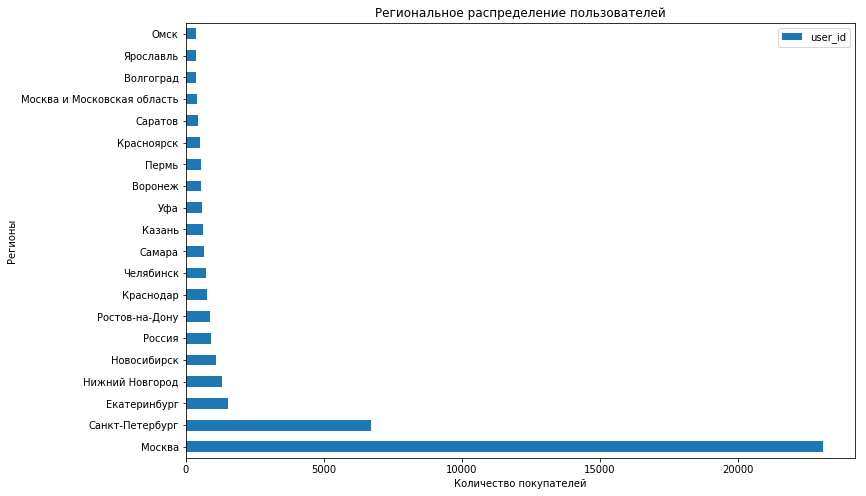

In [43]:
geo_plot(df[df['price']>0])

In [45]:
def category_plot(df):
    category_count = df.groupby('category', as_index = False).agg({'user_id':'nunique'}).sort_values('user_id', ascending = False).merge(cat_, left_on='category', right_on='hyper_cat_id').head(20)
    fig, ax = plt.subplots(figsize =(12,8)) 
    category_count.plot(kind='barh', x="category_name", y='user_id', ax = ax)
    ax.set(title='Популярные категории', xlabel = 'Количество покупателей', ylabel='Категории')
    

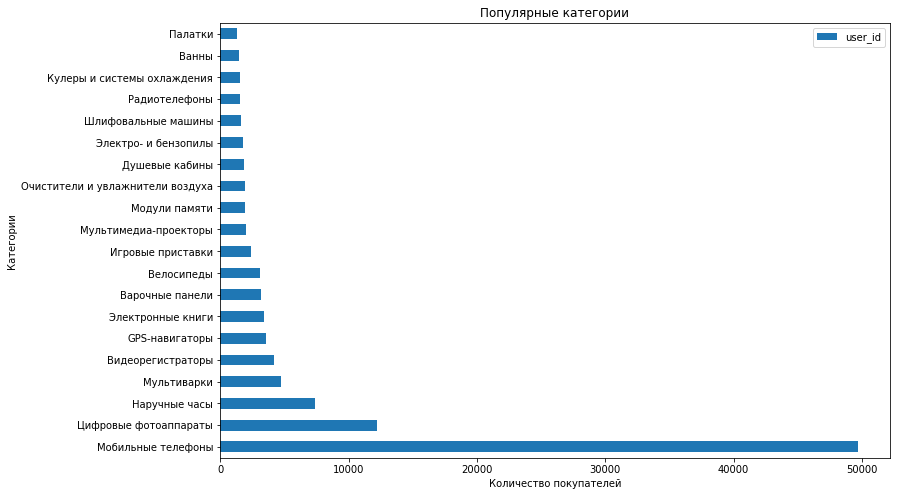

In [46]:
category_plot(df)

In [47]:
df.date_time.max()

Timestamp('2013-12-31 19:58:37')

In [48]:
df.date_time.min()

Timestamp('2012-12-31 20:00:53')

In [48]:
df_final = df.query("price > 0").copy()

In [49]:
df_final.head()

,timestamp,user_id,url_click,geo_id,category,price,date_time
64,1363416109,00023fcc5c93cb4674bdad0d448272e6,click,213,2662954,30.0,2013-03-16 06:41:49
65,1363154958,00023fcc5c93cb4674bdad0d448272e6,click,213,64270,10.0,2013-03-13 06:09:18
66,1363241850,00023fcc5c93cb4674bdad0d448272e6,click,213,64270,10.0,2013-03-14 06:17:30
67,1363242370,00023fcc5c93cb4674bdad0d448272e6,click,213,64270,10.0,2013-03-14 06:26:10
68,1363165672,00023fcc5c93cb4674bdad0d448272e6,click,213,64270,80.0,2013-03-13 09:07:52


In [51]:
#сруппируем покупателей к когорты в зависимости от месяца в котором они совершили первую покупку
# функция создает колонку в которой преобразует дату к первому дню месяца 
def get_month(x): return dt.datetime(x.year, x.month, 1)

# Apply function to invoice date to invoice month column
df_final['InvoiceMonth'] = df_final['date_time'].apply(get_month)
grouping1 = df_final.groupby('user_id')['InvoiceMonth']
df_final['CohortMonth'] = grouping1.transform('min')

In [52]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [53]:
invoice_year, invoice_month, _ = get_date_int(df_final, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(df_final, 'CohortMonth')

In [54]:
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

In [55]:
df_final['CohortIndex'] = years_diff * 12 + months_diff + 1
df_final.head()

,timestamp,user_id,url_click,geo_id,category,price,date_time,InvoiceMonth,CohortMonth,CohortIndex
64,1363416109,00023fcc5c93cb4674bdad0d448272e6,click,213,2662954,30.0,2013-03-16 06:41:49,2013-03-01,2013-01-01,3
65,1363154958,00023fcc5c93cb4674bdad0d448272e6,click,213,64270,10.0,2013-03-13 06:09:18,2013-03-01,2013-01-01,3
66,1363241850,00023fcc5c93cb4674bdad0d448272e6,click,213,64270,10.0,2013-03-14 06:17:30,2013-03-01,2013-01-01,3
67,1363242370,00023fcc5c93cb4674bdad0d448272e6,click,213,64270,10.0,2013-03-14 06:26:10,2013-03-01,2013-01-01,3
68,1363165672,00023fcc5c93cb4674bdad0d448272e6,click,213,64270,80.0,2013-03-13 09:07:52,2013-03-01,2013-01-01,3


In [56]:
revenue = df_final.groupby('InvoiceMonth', as_index = False)['price'].sum()

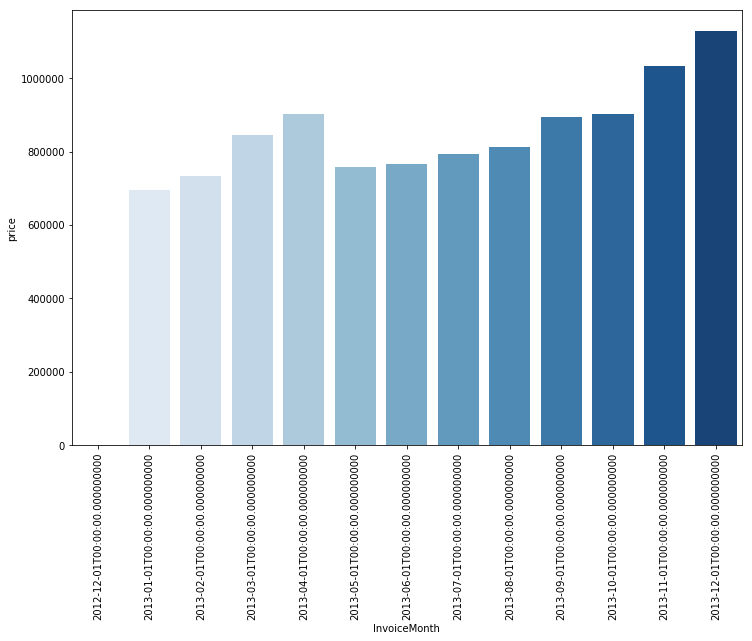

In [57]:
# revenue по месяцам 
plt.subplots(figsize=(12, 8))
sns.barplot(x="InvoiceMonth", y="price", data=revenue, palette="Blues")
plt.xticks(rotation=90)
plt.show()

In [58]:
df_final.head()

,timestamp,user_id,url_click,geo_id,category,price,date_time,InvoiceMonth,CohortMonth,CohortIndex
64,1363416109,00023fcc5c93cb4674bdad0d448272e6,click,213,2662954,30.0,2013-03-16 06:41:49,2013-03-01,2013-01-01,3
65,1363154958,00023fcc5c93cb4674bdad0d448272e6,click,213,64270,10.0,2013-03-13 06:09:18,2013-03-01,2013-01-01,3
66,1363241850,00023fcc5c93cb4674bdad0d448272e6,click,213,64270,10.0,2013-03-14 06:17:30,2013-03-01,2013-01-01,3
67,1363242370,00023fcc5c93cb4674bdad0d448272e6,click,213,64270,10.0,2013-03-14 06:26:10,2013-03-01,2013-01-01,3
68,1363165672,00023fcc5c93cb4674bdad0d448272e6,click,213,64270,80.0,2013-03-13 09:07:52,2013-03-01,2013-01-01,3


### RFM - анализ

Для RFM анализа нам потребуется сруппировать данные по пользователям и рассчитать их

- Recency
- Frequency
- Monitory

Также я считаю, что полезным будет рассчитать 

- количество уникальных категорий по которым пользователь осуществяет поиск
- средний чек

In [59]:
df_final.shape 

(363184, 10)

In [61]:
# в наших данный 55263 покупателей
df_final.user_id.nunique()

55263

In [151]:
RFM_full = df_final.groupby(['user_id'], as_index = False).agg({'category':'nunique', 'price':'sum', 'url_click':'count', 'date_time': lambda x:(df_final.date_time.max()-x.max()).days}) \
    .rename(columns = {'category':'category_count','price':'monetary', 'url_click':'frequency', 'date_time':'recency'})
RFM_full['avg_check'] = round(RFM_full.monetary/RFM_full.frequency,1)

RFM_full.head()

,user_id,category_count,monetary,frequency,recency,avg_check
0,00023fcc5c93cb4674bdad0d448272e6,10,425.0,25,69,17.0
1,00029bdb868e12bb62b8c574b274dbb7,1,90.0,5,362,18.0
2,00035d94fcd7e814d56531cf95b81ceb,1,159.0,3,149,53.0
3,00045ac92fb4ed78bc66c40f52775acd,1,50.0,5,58,10.0
4,00056ac58d63ef1d4b5fb73324bf845d,2,145.0,11,92,13.2


/Users/vasilisa/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


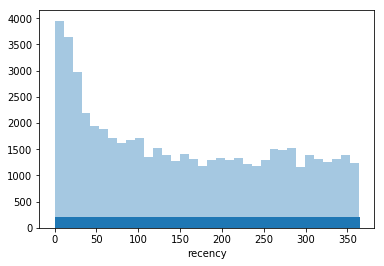

In [152]:
# распределение recency
plt.figsize=(8,5)
sns.distplot(RFM_full.recency, kde=False, rug=True)

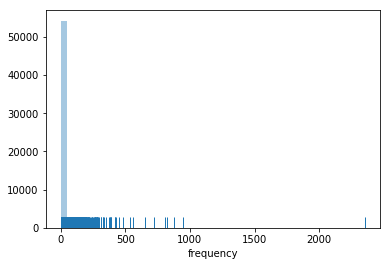

In [153]:
# распределение frequency
plt.figsize=(8,5)
sns.distplot(RFM_full.frequency, kde=False, rug=True)

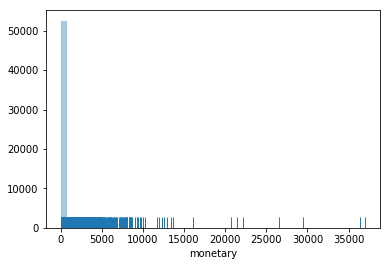

In [84]:
# распределение monetary
plt.figsize=(8,5)
sns.distplot(RFM_full.monetary, kde=False, rug=True)

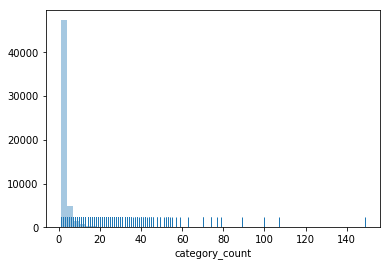

In [85]:
plt.figsize=(8,5)
sns.distplot(RFM_full.category_count, kde=False, rug=True)

Графики распределения Monetiry, Frequency, Recency сильно скошены в правую сторону. Для применения алгоритма KMeans оптимально распределение величин близкое к нормальному, применим np.log к каждой величине.

In [154]:
# покупатели с монетари больше 20000
RFM_full[RFM_full.monetary > 20000]

,user_id,category_count,monetary,frequency,recency,avg_check
9747,2d7b418fabedf226719558ef3072146d,149,22155.0,876,232,25.3
10578,319c306ff04738f35515934c456fffff,70,20734.0,723,109,28.7
29304,87d727bb28235675415163cafc8bb8fa,28,21423.0,946,21,22.6
30218,8c34533a937c9066c2da8e26b412564b,22,26537.0,257,0,103.3
41404,bfb0daace79694af558733a42625f1ce,40,37020.0,380,7,97.4
47993,defeadb89b8be2537812b0f27f5a1eb8,100,29427.0,2356,1,12.5
48351,e08754b3d7bb6814ede489f696c45eac,22,36408.0,805,221,45.2


In [160]:
#средний чек расчетная величина, ее не следует передавать в алгоритм kMeans во избежание высокой корреляции
def LogNorm(df):
    df1 = df
    for colname in df.columns[1:5]:
        df1['log'+colname] = np.log(df[colname] + 1)
    return df1

In [161]:
LogNorm(RFM_full)

,user_id,category_count,monetary,frequency,recency,avg_check,logmonetary,logfrequency,logrecency,cluster,logcategory_count
0,00023fcc5c93cb4674bdad0d448272e6,10,425.0,25,69,17.0,6.054439,3.258097,4.248495,2,2.397895
1,00029bdb868e12bb62b8c574b274dbb7,1,90.0,5,362,18.0,4.510860,1.791759,5.894403,4,0.693147
2,00035d94fcd7e814d56531cf95b81ceb,1,159.0,3,149,53.0,5.075174,1.386294,5.010635,4,0.693147
3,00045ac92fb4ed78bc66c40f52775acd,1,50.0,5,58,10.0,3.931826,1.791759,4.077537,0,0.693147
4,00056ac58d63ef1d4b5fb73324bf845d,2,145.0,11,92,13.2,4.983607,2.484907,4.532599,2,1.098612
...,...,...,...,...,...,...,...,...,...,...,...
55258,fffd82e6af96984f1dcc6ed961489341,9,150.0,10,263,15.0,5.017280,2.397895,5.575949,2,2.302585
55259,fffdaa6c1f0f36f7996d9845789e542c,3,172.0,4,83,43.0,5.153292,1.609438,4.430817,4,1.386294
55260,fffe0fa081a07ed3a4cbbcac47db8df0,1,14.0,1,41,14.0,2.708050,0.693147,3.737670,0,0.693147
55261,ffffd6bd3a3f1e7b3b92a790104a6ae4,2,263.0,15,283,17.5,5.575949,2.772589,5.648974,2,1.098612


/Users/vasilisa/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


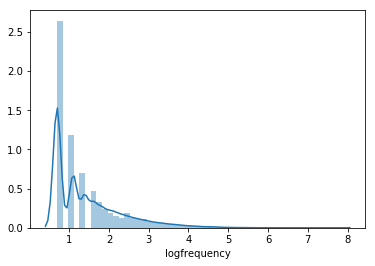

In [162]:
sns.distplot(RFM_full.logfrequency)

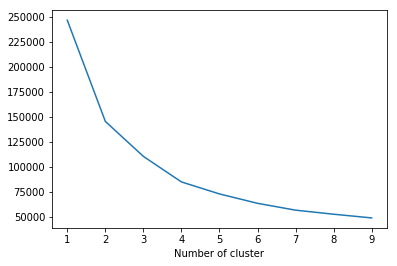

In [167]:
#посмотрим какое оптимальное поличество кластреов предлагает нам алгоритм
sse={}
RFM_ = RFM_full[['logmonetary','logfrequency','logrecency', 'logcategory_count']].copy(deep=True)

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(RFM_)
    RFM_['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_ 

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [168]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(RFM_)
RFM_full['cluster'] = kmeans.predict(RFM_)

In [169]:
RFM_full.head(10)

,user_id,category_count,monetary,frequency,recency,avg_check,logmonetary,logfrequency,logrecency,cluster,logcategory_count
0,00023fcc5c93cb4674bdad0d448272e6,10,425.0,25,69,17.0,6.054439,3.258097,4.248495,4,2.397895
1,00029bdb868e12bb62b8c574b274dbb7,1,90.0,5,362,18.0,4.510860,1.791759,5.894403,0,0.693147
2,00035d94fcd7e814d56531cf95b81ceb,1,159.0,3,149,53.0,5.075174,1.386294,5.010635,0,0.693147
3,00045ac92fb4ed78bc66c40f52775acd,1,50.0,5,58,10.0,3.931826,1.791759,4.077537,2,0.693147
4,00056ac58d63ef1d4b5fb73324bf845d,2,145.0,11,92,13.2,4.983607,2.484907,4.532599,0,1.098612
5,000583e5a29b33f1f608d6c001e56f31,2,130.0,13,259,10.0,4.875197,2.639057,5.560682,0,1.098612
6,0005ed3cc99ddb0def30bf53466366ee,1,75.0,6,23,12.5,4.330733,1.945910,3.178054,2,0.693147
7,000ae3d1d7986733826f02b7bddef036,1,22.0,1,3,22.0,3.135494,0.693147,1.386294,2,0.693147
8,000b71102168827ca5271edbdc20c908,1,10.0,1,239,10.0,2.397895,0.693147,5.480639,1,0.693147
9,000cc187d45637f927e56b9fa0ef5f88,1,11.0,1,84,11.0,2.484907,0.693147,4.442651,1,0.693147


In [201]:
# Соберем в DataFrame подробное описание категорий предложенных kMeans
def cluster_describe(df):
    df1 = pd.DataFrame()
    df1['user_count'] = df.groupby('cluster')['user_id'].transform('count')
    for colname in df.columns[1:5]:
        df1['cluster'] = df['cluster']
        df1[colname + '_min'] = df.groupby('cluster')[colname].transform('min')
        df1[colname + '_max'] = df.groupby('cluster')[colname].transform('max')
        
    
    return df1.drop_duplicates().set_index('cluster').sort_index()

In [203]:
# функция - сгруппировать данные по кластерам
def cluster(df):
    RFM_cluster = df.groupby(['cluster']) \
    .agg({'category_count':'mean', 'avg_check':'mean','monetary':'mean','frequency':'median','recency':'median', 'user_id':'nunique'}) \
    .sort_values('monetary') \
    .rename(columns = {'user_id':'users'})
    RFM_cluster['money'] = round(RFM_cluster['monetary'] * RFM_cluster['users'], 2)
    return RFM_cluster.head()
    

In [202]:
cluster_describe(RFM_full)

,user_count,category_count_min,category_count_max,monetary_min,monetary_max,frequency_min,frequency_max,recency_min,recency_max
cluster,,,,,,,,,
0,26511,1,10,16.0,1940.0,1,23,28,364
1,11447,1,2,5.0,22.0,1,3,37,364
2,8966,1,7,5.0,343.0,1,10,0,64
3,4304,1,107,70.0,37020.0,1,2356,0,44
4,4035,1,149,149.0,36408.0,2,876,30,362


In [205]:
cluster(RFM_full).sort_index()

,category_count,avg_check,monetary,frequency,recency,users,money
cluster,,,,,,,
0,1.748557,41.112734,108.965222,3,199,26511,2888777.0
1,1.009697,10.963746,11.066742,1,204,11447,126681.0
2,1.399955,29.988813,49.911778,2,22,8966,447509.0
3,6.592240,41.600511,714.052742,13,12,4304,3073283.0
4,7.039901,42.094572,923.956382,20,144,4035,3728164.0


#### 0 категория - At risk customers 

26511, Эти покупатели заходили в сервис, 
искали товары по нескольким категориям, Monetary вышк среднего значения, но уже давно не пользовались сервисом
Цель - подтолкнуть их к следующим действиям, напомнить о себе, возобновить контакт.

#### 1 категория - Churn

11447, покупатели которые уже больше месяца не пользуются сервиом, медианное значение 204 дня. Они заходили в сервис однократно и скорее всего случайно. 
Цель  - убедить их в необходимости сервиса.

#### 2 категория - Fresh leads 

8966, только что зарегестрированные пользователи, пробуют сервис,
Цель - показать выгоду от использования сервиса (скидки на первую покупку)

#### 3 категория - Loyal New Customers 

4304 максимальный возраст этих покупателей 44 дня, но они очень активно пользуются сервисом. Ищут товары в нескольких категориях и часто.
Цель - изучить их лучше, чтобы предоставить им лучший сервис и сохранить отношения надолго.

#### 4 Категория - Cannot lose 

4035, этих покупателей можно отнести к лояльным покупателям, они с сервисом уже около года, в этой категории самые высокае Monetary и Frequency, в какой-то момент они были лучшими,
но риск связан с тем что эти замечательные покупатели уже больше месяца не пользуются сервисом.
Возможно это связано со структурой их покупок. Возможно есть другие причины.
Цель - вернуть их назад.


In [197]:
df_final = df_final.merge(RFM_full[['user_id', 'cluster']],  how = 'left', on = 'user_id')

In [198]:
df_final.head()

,timestamp,user_id,url_click,geo_id,category,price,date_time,InvoiceMonth,CohortMonth,CohortIndex,cluster
0,1363416109,00023fcc5c93cb4674bdad0d448272e6,click,213,2662954,30.0,2013-03-16 06:41:49,2013-03-01,2013-01-01,3,4
1,1363154958,00023fcc5c93cb4674bdad0d448272e6,click,213,64270,10.0,2013-03-13 06:09:18,2013-03-01,2013-01-01,3,4
2,1363241850,00023fcc5c93cb4674bdad0d448272e6,click,213,64270,10.0,2013-03-14 06:17:30,2013-03-01,2013-01-01,3,4
3,1363242370,00023fcc5c93cb4674bdad0d448272e6,click,213,64270,10.0,2013-03-14 06:26:10,2013-03-01,2013-01-01,3,4
4,1363165672,00023fcc5c93cb4674bdad0d448272e6,click,213,64270,80.0,2013-03-13 09:07:52,2013-03-01,2013-01-01,3,4


In [245]:
clients = RFM_full.merge(df_final[['geo_id','category', 'user_id']], how = 'left', on = 'user_id')

In [344]:
clients.head()

,user_id,category_count,monetary,frequency,recency,avg_check,logmonetary,logfrequency,logrecency,cluster,logcategory_count,geo_id,category
0,00023fcc5c93cb4674bdad0d448272e6,10,425.0,25,69,17.0,6.054439,3.258097,4.248495,4,2.397895,213,2662954
1,00023fcc5c93cb4674bdad0d448272e6,10,425.0,25,69,17.0,6.054439,3.258097,4.248495,4,2.397895,213,64270
2,00023fcc5c93cb4674bdad0d448272e6,10,425.0,25,69,17.0,6.054439,3.258097,4.248495,4,2.397895,213,64270
3,00023fcc5c93cb4674bdad0d448272e6,10,425.0,25,69,17.0,6.054439,3.258097,4.248495,4,2.397895,213,64270
4,00023fcc5c93cb4674bdad0d448272e6,10,425.0,25,69,17.0,6.054439,3.258097,4.248495,4,2.397895,213,64270


#### Когортный анализ - Retention

In [222]:
def monthly_cohort(df, num_cluster):
    # Count monthly active customers from each cohort
    grouping_count = df[df.cluster == num_cluster].groupby(['CohortMonth', 'CohortIndex'])
    cohort_data = grouping_count['user_id'].apply(pd.Series.nunique)
    cohort_data = cohort_data.reset_index()
    cohort_counts = cohort_data.pivot(index='CohortMonth',
                                      columns='CohortIndex',
                                          values='user_id')
    # Calculate Retention Rate
    cohort_sizes = cohort_counts.iloc[:,0]
    retention = cohort_counts.divide(cohort_sizes, axis=0)
    retention.round(3) * 100
    retention.index = retention.index.strftime('%m-%Y')
    
    # Plot retention rates
    plt.figure(figsize=(10, 8))
    plt.title('Retention rates')
    sns.heatmap(data = retention, annot = True, fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
    plt.show()
    
    return cohort_counts

def monthly_avg_price(df, num_cluster):
    # Calculate Average Price
    grouping_price = df[df.cluster == num_cluster].groupby(['CohortMonth', 'CohortIndex'])
    cohort_data_price = grouping_price['price'].mean()
    cohort_data_price = cohort_data_price.reset_index()
    average_price = cohort_data_price.pivot(index='CohortMonth',
                                         columns='CohortIndex',
                                         values='price')
    average_price.index = average_price.index.strftime('%m-%Y')

    #Plot average price
    plt.figure(figsize=(10, 8))
    plt.title('Average Price')
    sns.heatmap(data = average_price, annot=True, cmap='Blues')
    plt.show()
    
    return average_price

In [223]:
# Москва и Санкт-Петербург
cluster(clients.query("geo_id == 1 | geo_id == 2"))

,category_count,avg_check,monetary,frequency,recency,users,money
cluster,,,,,,,
1,1.013168,11.029435,11.201394,1,216,1277,14304.18
2,1.720363,20.939197,58.953155,3,22,905,53352.61
0,2.195238,30.025584,138.432796,5,200,3673,508463.66
3,12.338768,27.320177,1820.320693,39,9,696,1266943.20
4,14.245990,29.373427,2811.209153,46,146,597,1678291.86


In [368]:
# Регионы
cluster(clients.query("geo_id != 1 | geo_id != 2"))

,category_count,avg_check,monetary,frequency,recency,users,money
cluster,,,,,,,
1,1.019206,10.910430,11.116097,1,203,11447,127245.96
2,1.702972,22.850123,58.006536,3,22,8966,520086.60
0,2.226460,28.724779,135.713190,5,195,26511,3597892.39
4,12.447030,30.266616,2102.834696,39,146,4035,8484938.00
3,17.204543,28.389305,2878.354888,45,9,4304,12388439.44


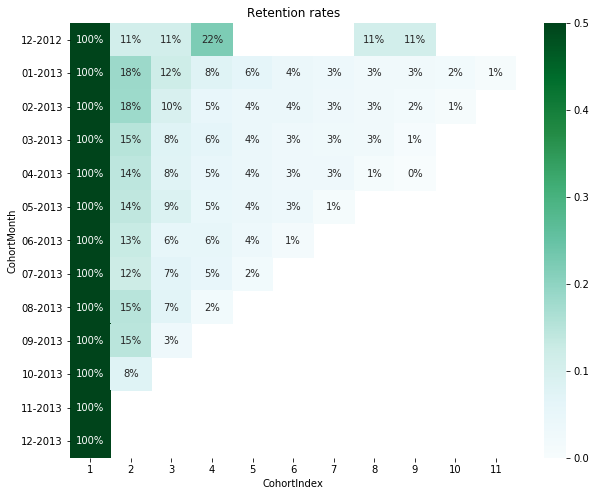

CohortIndex,1,2,3,4,5,6,7,8,9,10,11
CohortMonth,,,,,,,,,,,
2012-12-01,9.0,1.0,1.0,2.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN
2013-01-01,3816.0,701.0,459.0,297.0,233.0,168.0,132.0,101.0,100.0,75.0,31.0
2013-02-01,2762.0,505.0,269.0,148.0,119.0,116.0,89.0,74.0,49.0,24.0,NaN
2013-03-01,2958.0,449.0,228.0,180.0,130.0,95.0,90.0,74.0,18.0,NaN,NaN
2013-04-01,2730.0,393.0,207.0,142.0,113.0,89.0,90.0,34.0,1.0,NaN,NaN
2013-05-01,2260.0,317.0,196.0,107.0,94.0,77.0,23.0,NaN,NaN,NaN,NaN
2013-06-01,2139.0,279.0,120.0,122.0,76.0,30.0,NaN,NaN,NaN,NaN,NaN
2013-07-01,2197.0,273.0,147.0,113.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-01,2295.0,344.0,164.0,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [345]:
# Retention в 0 кластере 
monthly_cohort(df_final, 0)

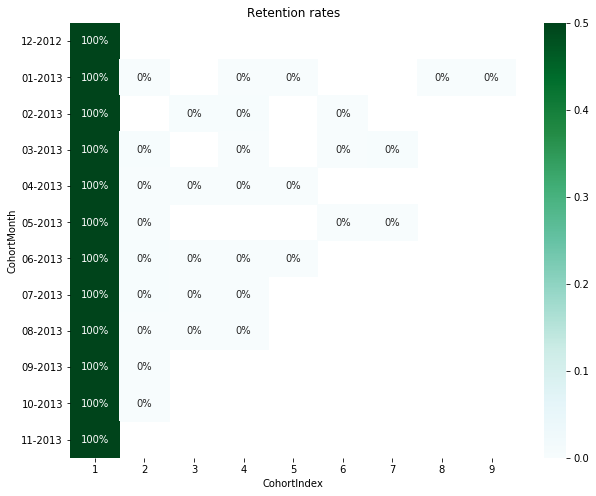

CohortIndex,1,2,3,4,5,6,7,8,9
CohortMonth,,,,,,,,,
2012-12-01,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1301.0,1.0,NaN,1.0,2.0,NaN,NaN,2.0,2.0
2013-02-01,990.0,NaN,2.0,2.0,NaN,1.0,NaN,NaN,NaN
2013-03-01,1079.0,5.0,NaN,1.0,NaN,1.0,3.0,NaN,NaN
2013-04-01,1097.0,2.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN
2013-05-01,990.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN
2013-06-01,883.0,3.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
2013-07-01,1008.0,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2013-08-01,1026.0,2.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN


In [363]:
# Retention в 1 кластере 
monthly_cohort(df_final, 1)

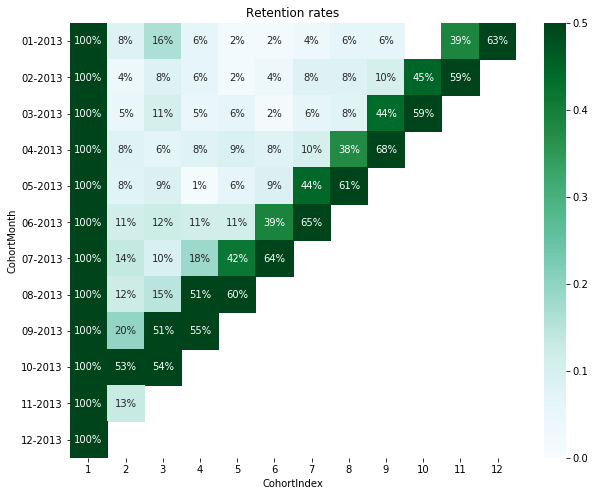

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2013-01-01,49.0,4.0,8.0,3.0,1.0,1.0,2.0,3.0,3.0,NaN,19.0,31.0
2013-02-01,49.0,2.0,4.0,3.0,1.0,2.0,4.0,4.0,5.0,22.0,29.0,NaN
2013-03-01,66.0,3.0,7.0,3.0,4.0,1.0,4.0,5.0,29.0,39.0,NaN,NaN
2013-04-01,77.0,6.0,5.0,6.0,7.0,6.0,8.0,29.0,52.0,NaN,NaN,NaN
2013-05-01,79.0,6.0,7.0,1.0,5.0,7.0,35.0,48.0,NaN,NaN,NaN,NaN
2013-06-01,72.0,8.0,9.0,8.0,8.0,28.0,47.0,NaN,NaN,NaN,NaN,NaN
2013-07-01,103.0,14.0,10.0,19.0,43.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-01,129.0,16.0,19.0,66.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-09-01,179.0,35.0,92.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [364]:
# Retention в 2 кластере 
monthly_cohort(df_final, 2)

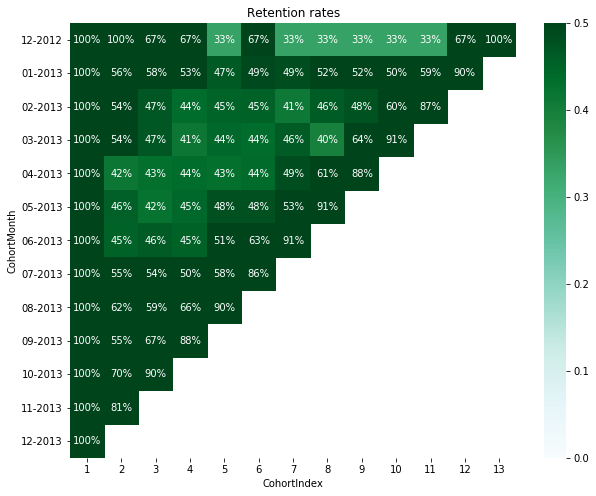

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2012-12-01,3.0,3.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0
2013-01-01,472.0,265.0,273.0,251.0,220.0,233.0,229.0,245.0,246.0,237.0,279.0,427.0,NaN
2013-02-01,275.0,149.0,129.0,120.0,124.0,125.0,113.0,127.0,131.0,165.0,240.0,NaN,NaN
2013-03-01,241.0,129.0,113.0,100.0,107.0,105.0,112.0,96.0,155.0,219.0,NaN,NaN,NaN
2013-04-01,202.0,84.0,87.0,88.0,87.0,89.0,98.0,124.0,178.0,NaN,NaN,NaN,NaN
2013-05-01,191.0,87.0,81.0,85.0,92.0,92.0,101.0,173.0,NaN,NaN,NaN,NaN,NaN
2013-06-01,183.0,83.0,85.0,83.0,93.0,115.0,166.0,NaN,NaN,NaN,NaN,NaN,NaN
2013-07-01,237.0,130.0,127.0,119.0,138.0,205.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-01,293.0,182.0,172.0,194.0,265.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [365]:
# Retention в 3 кластере 
monthly_cohort(df_final, 3)

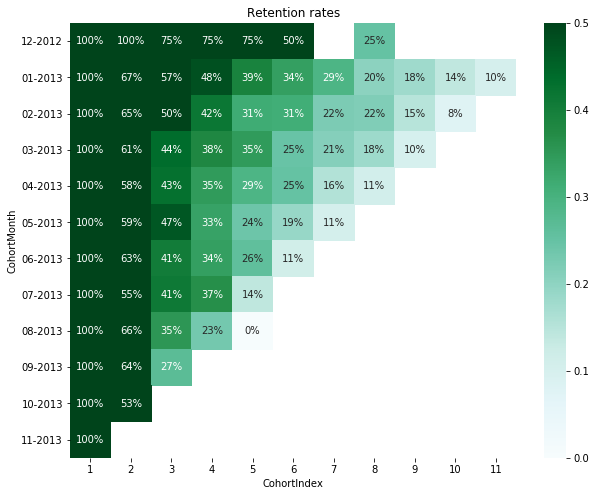

CohortIndex,1,2,3,4,5,6,7,8,9,10,11
CohortMonth,,,,,,,,,,,
2012-12-01,4.0,4.0,3.0,3.0,3.0,2.0,NaN,1.0,NaN,NaN,NaN
2013-01-01,1168.0,787.0,668.0,563.0,458.0,395.0,341.0,238.0,210.0,162.0,120.0
2013-02-01,553.0,362.0,276.0,231.0,174.0,172.0,124.0,120.0,84.0,44.0,NaN
2013-03-01,438.0,265.0,191.0,167.0,152.0,108.0,93.0,80.0,44.0,NaN,NaN
2013-04-01,387.0,226.0,166.0,134.0,113.0,97.0,61.0,43.0,NaN,NaN,NaN
2013-05-01,319.0,187.0,150.0,106.0,77.0,61.0,34.0,NaN,NaN,NaN,NaN
2013-06-01,254.0,159.0,103.0,86.0,66.0,29.0,NaN,NaN,NaN,NaN,NaN
2013-07-01,226.0,124.0,93.0,83.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-01,248.0,164.0,88.0,58.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [366]:
# Retention в 4 кластере 
monthly_cohort(df_final, 4)

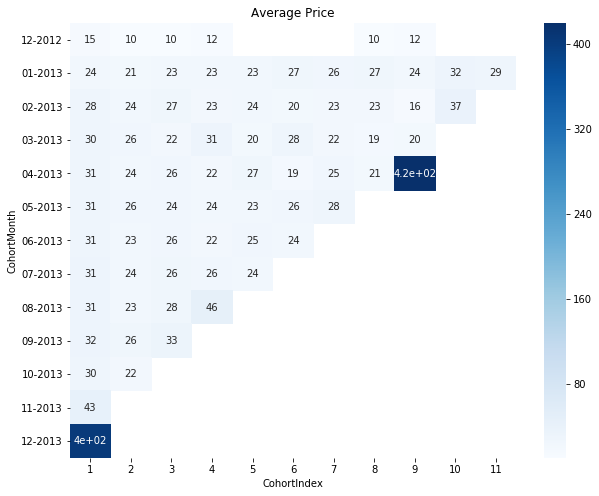

CohortIndex,1,2,3,4,5,6,7,8,9,10,11
CohortMonth,,,,,,,,,,,
12-2012,15.333333,10.000000,10.333333,12.333333,NaN,NaN,NaN,10.000000,12.000000,NaN,NaN
01-2013,23.983155,20.905671,23.386521,23.072441,23.015625,27.295265,25.839844,26.734884,23.894118,31.930380,29.294118
02-2013,27.719069,24.162041,26.600000,22.671733,24.328244,20.115044,22.766667,22.529851,15.793478,37.295455,NaN
03-2013,29.571229,25.840929,22.137864,31.154891,20.231618,27.822335,22.112500,18.687023,20.166667,NaN,NaN
04-2013,30.556310,23.549325,25.793750,21.650519,26.754808,18.598131,24.559322,21.028986,420.000000,NaN,NaN
05-2013,30.564481,25.777377,24.462810,24.204444,22.818653,25.691860,28.469388,NaN,NaN,NaN,NaN
06-2013,30.558951,23.141593,25.605263,22.131687,24.637681,23.861111,NaN,NaN,NaN,NaN,NaN
07-2013,31.483781,23.997429,26.184290,25.559184,23.834951,NaN,NaN,NaN,NaN,NaN,NaN
08-2013,31.248729,23.012128,27.590659,46.037500,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [351]:
#анализ динамики средней цены в 0 кластере
monthly_avg_price(df_final, 0)

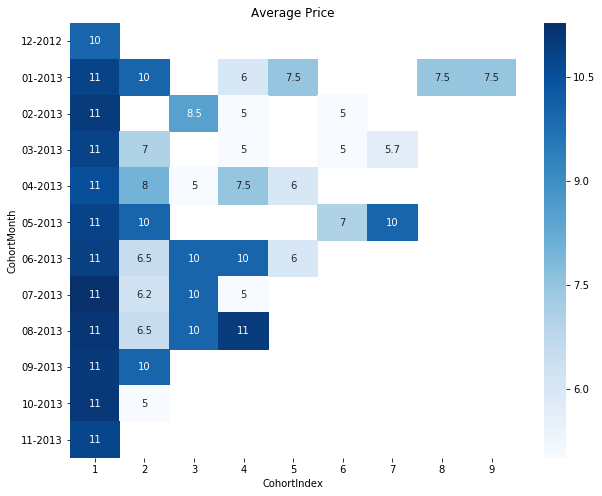

CohortIndex,1,2,3,4,5,6,7,8,9
CohortMonth,,,,,,,,,
12-2012,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01-2013,10.824201,10.00,NaN,6.0,7.5,NaN,NaN,7.5,7.5
02-2013,10.995968,NaN,8.5,5.0,NaN,5.0,NaN,NaN,NaN
03-2013,10.829826,7.00,NaN,5.0,NaN,5.0,5.666667,NaN,NaN
04-2013,10.532432,8.00,5.0,7.5,6.0,NaN,NaN,NaN,NaN
05-2013,10.824000,10.00,NaN,NaN,NaN,7.0,10.000000,NaN,NaN
06-2013,10.899775,6.50,10.0,10.0,6.0,NaN,NaN,NaN,NaN
07-2013,11.284180,6.25,10.0,5.0,NaN,NaN,NaN,NaN,NaN
08-2013,11.119691,6.50,10.0,11.0,NaN,NaN,NaN,NaN,NaN


In [352]:
#анализ динамики средней цены в 1 кластере
monthly_avg_price(df_final, 1)

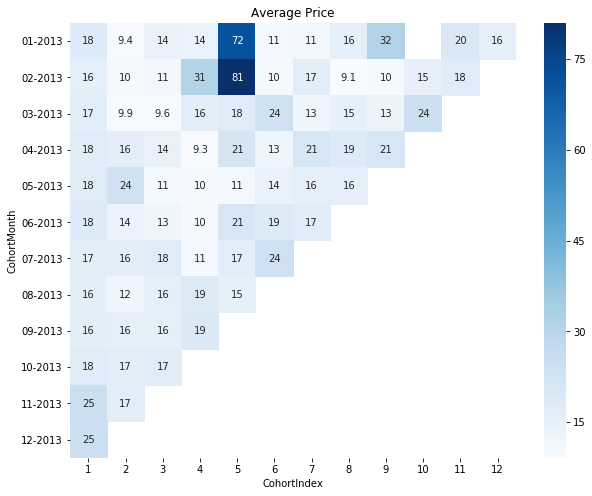

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
01-2013,18.474359,9.400000,14.272727,14.000000,72.000000,11.000000,11.250000,15.833333,31.75,NaN,19.730769,15.604651
02-2013,15.621212,10.000000,11.200000,31.333333,81.000000,10.500000,16.833333,9.100000,10.00,15.216216,17.795455,NaN
03-2013,17.093023,9.857143,9.600000,16.333333,17.750000,23.500000,12.600000,15.285714,13.25,24.471698,NaN,NaN
04-2013,17.991453,16.250000,14.444444,9.285714,21.454545,12.666667,20.900000,18.511111,21.00,NaN,NaN,NaN
05-2013,17.530973,23.900000,11.000000,10.000000,10.777778,14.428571,15.744681,15.681159,NaN,NaN,NaN,NaN
06-2013,18.479167,13.636364,12.583333,10.000000,20.833333,18.522727,17.406780,NaN,NaN,NaN,NaN,NaN
07-2013,16.753086,16.235294,17.666667,10.920000,17.166667,24.148515,NaN,NaN,NaN,NaN,NaN,NaN
08-2013,16.461165,12.458333,15.791667,18.836538,15.410853,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09-2013,16.479592,15.615385,15.774834,19.447368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [353]:
# анализ динамики средней цены во 2 кластере
monthly_avg_price(df_final, 2)

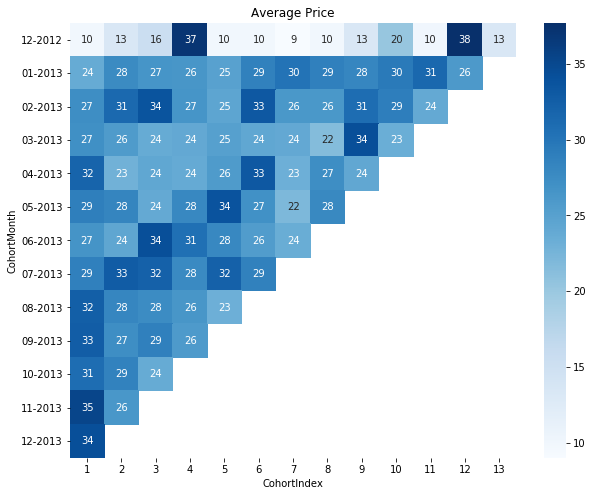

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
12-2012,10.000000,13.437500,15.500000,37.125000,10.000000,10.000000,9.000000,10.000000,13.440000,20.250000,10.111111,37.714286,13.454545
01-2013,23.755003,27.726351,26.574927,26.447711,24.939638,28.845047,30.199786,28.907719,28.269288,29.564268,31.448493,25.978871,NaN
02-2013,27.334831,31.417783,33.700565,26.555245,24.527820,33.282235,26.270736,26.167358,30.976658,29.078975,23.983210,NaN,NaN
03-2013,27.082000,25.715328,23.774155,24.071849,25.196474,24.341188,24.095642,21.619327,34.311426,23.402950,NaN,NaN,NaN
04-2013,31.985816,22.934866,24.351351,23.829832,25.767327,33.281377,23.219634,27.296736,24.233161,NaN,NaN,NaN,NaN
05-2013,29.012133,28.332283,23.927143,27.957912,33.811429,26.949675,22.039706,27.856881,NaN,NaN,NaN,NaN,NaN
06-2013,26.642766,24.442561,34.325482,30.579060,27.956835,25.698690,23.572657,NaN,NaN,NaN,NaN,NaN,NaN
07-2013,28.853614,32.878822,32.274490,27.796771,32.223387,28.841895,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08-2013,32.461589,28.283212,27.527073,26.439597,23.161644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [367]:
# анализ динамики средней цены во 3 кластере
monthly_avg_price(df_final, 3)

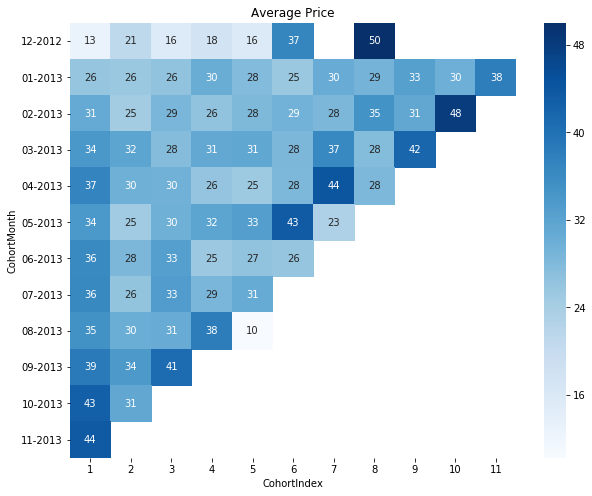

CohortIndex,1,2,3,4,5,6,7,8,9,10,11
CohortMonth,,,,,,,,,,,
12-2012,12.833333,21.254545,15.517241,17.719298,15.754386,37.000000,NaN,50.000000,NaN,NaN,NaN
01-2013,26.041501,25.547765,26.468277,30.317976,27.816662,25.481003,30.450044,29.075047,32.642127,29.855543,38.170927
02-2013,30.841690,24.670394,28.574702,26.400000,28.178686,29.449959,28.428571,34.805732,31.342975,48.083832,NaN
03-2013,34.126559,31.744156,27.577918,31.192982,31.371917,28.425614,36.508475,27.678959,41.624060,NaN,NaN
04-2013,37.240781,29.803780,29.566052,26.103653,25.172914,28.307143,44.189840,28.272031,NaN,NaN,NaN
05-2013,33.946064,24.959404,29.717226,31.704523,33.062612,43.471092,23.045685,NaN,NaN,NaN,NaN
06-2013,36.270709,28.442424,32.822961,25.414264,26.521257,25.973684,NaN,NaN,NaN,NaN,NaN
07-2013,36.348111,26.361052,33.270601,28.615265,30.717703,NaN,NaN,NaN,NaN,NaN,NaN
08-2013,35.007019,30.245820,30.519621,38.231454,10.250000,NaN,NaN,NaN,NaN,NaN,NaN


In [355]:
# анализ динамики средней цены во 4 кластере
monthly_avg_price(df_final, 4)

#### RFM by category

Посмотрим на распределение RFM внутри каждого кластера по регионам и в столицах(Москва и Санкт-Петербург)

In [331]:
def category_by_cluster(df, clust):
    category_by = df[df.cluster == clust].merge(cat_, left_on='category', right_on='hyper_cat_id').groupby(['category']) \
        .agg({'category_name':'unique',
              'user_id':'nunique', 
              'url_click':'count', 
              'price':'sum',
              'date_time': lambda x:(df_final.date_time.max()-x.max()).days}).sort_values('user_id',ascending = False) \
    .rename(columns = {'user_id':'users', 'url_click':'frequency', 'price':'monetary', 'date_time':'recency'})
    category_by['user_percent'] = round(category_by['users']/df[df.cluster == clust]['user_id'].nunique()*100)
    return category_by

In [340]:
# как распределяются категории в Столицах внутри кластера 0
# user_percent - процент пользователей от общего количества пользователей в кластере
capitals_category_0 = category_by_cluster(df_final.query("geo_id == 1 | geo_id == 2"), 0)
capitals_category_0.head()

,category_name,users,frequency,monetary,recency,user_percent
category,,,,,,
91491,[Мобильные телефоны],708,2004,79862.0,33,19.0
91148,[Цифровые фотоаппараты],107,230,12608.0,34,3.0
91498,[Чехлы],71,163,2268.0,46,2.0
4954975,[Мультиварки],63,128,7759.0,60,2.0
2662954,[Чехлы для планшетов],59,140,3252.0,37,2.0


In [341]:
# как распределяются категории в Регионах внутри кластера 0
# user_percent - процент пользователей от общего количества пользователей в кластере
region_category_0 = category_by_cluster(df_final.query("geo_id != 1 | geo_id != 2"), 0)
region_category_0.head()

,category_name,users,frequency,monetary,recency,user_percent
category,,,,,,
91491,[Мобильные телефоны],5214,14829,479698.0,33,20.0
91148,[Цифровые фотоаппараты],791,1875,78189.0,29,3.0
4954975,[Мультиварки],476,1102,51593.0,34,2.0
91498,[Чехлы],346,806,12994.0,46,1.0
91259,[Наручные часы],339,725,28531.0,40,1.0


In [338]:
# как распределяются категории в Столицах внутри кластера 1
# user_percent - процент пользователей от общего количества пользователей в кластере
capitals_category_1 = category_by_cluster(df_final.query("geo_id == 1 | geo_id == 2"), 1)
capitals_category_1.head()

,category_name,users,frequency,monetary,recency,user_percent
category,,,,,,
91491,[Мобильные телефоны],166,166,1796.0,43,13.0
91148,[Цифровые фотоаппараты],16,16,187.0,50,1.0
91529,[Велосипеды],14,14,173.0,96,1.0
2662954,[Чехлы для планшетов],11,11,131.0,83,1.0
2417247,[Электронные книги],11,11,117.0,51,1.0


In [339]:
# как распределяются категории в Регионах внутри кластера 1
# user_percent - процент пользователей от общего количества пользователей в кластере
region_category_1 = category_by_cluster(df_final.query("geo_id != 1 | geo_id != 2"), 1)
region_category_1.head()

,category_name,users,frequency,monetary,recency,user_percent
category,,,,,,
91491,[Мобильные телефоны],1535,1535,16926.0,42,13.0
91148,[Цифровые фотоаппараты],215,215,2402.0,46,2.0
4954975,[Мультиварки],93,93,1017.0,42,1.0
91259,[Наручные часы],88,88,989.0,43,1.0
91137,[Игры для ПК],78,78,886.0,54,1.0


In [332]:
# как распределяются категории в Столицах внутри кластера 2
# user_percent - процент пользователей от общего количества пользователей в кластере
capitals_category_2 = category_by_cluster(df_final.query("geo_id == 1 | geo_id == 2"), 2)
capitals_category_2.head()

,category_name,users,frequency,monetary,recency,user_percent
category,,,,,,
91491,[Мобильные телефоны],150,297,7631.0,1,17.0
91259,[Наручные часы],19,32,720.0,1,2.0
91148,[Цифровые фотоаппараты],18,27,708.0,2,2.0
4954975,[Мультиварки],16,27,982.0,1,2.0
91122,[Игровые приставки],14,33,616.0,6,2.0


In [333]:
# как распределяются категории в Регионах внутри кластера 2
# user_percent - процент пользователей от общего количества пользователей в кластере
region_category_2 = category_by_cluster(df_final.query("geo_id != 1 | geo_id != 2"), 2)
region_category_2.head()

,category_name,users,frequency,monetary,recency,user_percent
category,,,,,,
91491,[Мобильные телефоны],1531,2790,75579.0,0,17.0
91148,[Цифровые фотоаппараты],216,340,10281.0,0,2.0
91259,[Наручные часы],116,186,6045.0,1,1.0
91122,[Игровые приставки],116,177,4216.0,0,1.0
4954975,[Мультиварки],101,156,4857.0,0,1.0


In [334]:
# как распределяются категории в Столицах внутри кластера 3
# user_percent - процент пользователей от общего количества пользователей в кластере
capitals_category_3 = category_by_cluster(df_final.query("geo_id == 1 | geo_id == 2"), 3)
capitals_category_3.head()

,category_name,users,frequency,monetary,recency,user_percent
category,,,,,,
91491,[Мобильные телефоны],278,2176,78961.0,0,40.0
91148,[Цифровые фотоаппараты],68,316,13840.0,3,10.0
4954975,[Мультиварки],35,85,2864.0,1,5.0
91259,[Наручные часы],29,120,3353.0,1,4.0
2662954,[Чехлы для планшетов],26,69,1596.0,5,4.0


In [335]:
# как распределяются категории в Регионах внутри кластера 3
# user_percent - процент пользователей от общего количества пользователей в кластере
region_category_3 = category_by_cluster(df_final.query("geo_id != 1 | geo_id != 2"), 3)
region_category_3.head()

,category_name,users,frequency,monetary,recency,user_percent
category,,,,,,
91491,[Мобильные телефоны],1870,16409,447127.0,0,43.0
91148,[Цифровые фотоаппараты],416,2413,115157.0,0,10.0
4954975,[Мультиварки],284,1138,51620.0,0,7.0
91259,[Наручные часы],216,910,29181.0,0,5.0
91498,[Чехлы],189,561,9839.0,0,4.0


In [342]:
# как распределяются категории в Столицах внутри кластера 4
# user_percent - процент пользователей от общего количества пользователей в кластере
capitals_category_4 = category_by_cluster(df_final.query("geo_id == 1 | geo_id == 2"), 4)
capitals_category_4.head()

,category_name,users,frequency,monetary,recency,user_percent
category,,,,,,
91491,[Мобильные телефоны],270,3125,115831.0,37,45.0
91148,[Цифровые фотоаппараты],71,349,19767.0,51,12.0
91498,[Чехлы],46,141,2238.0,52,8.0
6269371,[Видеорегистраторы],38,172,3974.0,53,6.0
4954975,[Мультиварки],37,181,6877.0,73,6.0


In [343]:
# как распределяются категории в Регионах внутри кластера 4
# user_percent - процент пользователей от общего количества пользователей в кластере
region_category_4 = category_by_cluster(df_final.query("geo_id != 1 | geo_id != 2"), 4)
region_category_4.head()

,category_name,users,frequency,monetary,recency,user_percent
category,,,,,,
91491,[Мобильные телефоны],1798,17740,568610.0,35,45.0
91148,[Цифровые фотоаппараты],415,2512,119817.0,33,10.0
4954975,[Мультиварки],279,1410,65124.0,33,7.0
91498,[Чехлы],237,845,13845.0,44,6.0
6269371,[Видеорегистраторы],207,995,29325.0,40,5.0


## Рекомендации:
    
#### 0 категория - At risk customers

26511, Эти покупатели заходили в сервис, искали товары по нескольким категориям, Monetary выше среднего значения, но уже давно не пользовались сервисом.

Цель - подтолкнуть их к следующим действиям, напомнить о себе, возобновить контакт.

Рекомендации - Retention резко падает во втором месяце, поэтому важно прилагать усилия для того чтобы удержать имеющихся клиентов. 
Проанализировать историю поиска, предложить акции на запрашиваеме товары от интернет-магазинов размещающие товары на маркете.
Вовлекать их в сервис предлагая товары из смежных категорий, релевантые их поиску.  Увеличение интереса к дополнительным категориям товаров увеличит Frequency и как сделствие LTV.
Интерес к сервису снизит отток покупателей.

Увеличиваем кликабельность: выводим акционные предложения интернет-магазинов на первое место в результатах поиска, предлагаем товары из сопуствующих категорий.
Увеличиваем частоту контакта: рассылка, уведомления и т.д.

#### 1 категория - Churn
11447, покупатели которые уже больше месяца не пользуются сервиом, медианное значение 204 дня. Они заходили в сервис однократно и скорее всего случайно. 

Цель - убедить их в необходимости сервиса.

Рекомендации - формирование информационного поля вокруг данных покупателей. Рассказываем о сервисе о новых удобных нововедениях. Мотивируем попробовать сервис вновь.
Увеличиваем частоту контакта.


##### 2 категория - Fresh leads

8966, только что зарегестрированные пользователи либо пользователи пришедшие через лид, пробуют сервис, Цель - показать выгоду от использования сервиса (скидки на первую покупку)
Судя по графику Retention в этом кластре им было сделано предложение в октябре 2013 года, на которое они очень хорошо отреагировали и на протяжении последующих двух месяцев проявляют интерес к сервису.

Рекомендации поддеживать интерес к сервису, в зависимости от того какие изменения были введены в сервис для этих пользователей в октябре продалжать их и следить за динамикой.


##### 3 категория - Loyal New Customers

4304, максимальный возраст этих покупателей 44 дня, но они очень активно пользуются сервисом. Ищут товары в нескольких категориях и часто. Цель - изучить их лучше, чтобы предоставить им лучший сервис и сохранить
отношения надолго.

50% пользователей этого кластрера интересуются сложной техникой телефонами и фотоаппаратами. Предположу, что пользователи этого кластера в активном поиске техники.

Рекомендации - проанализировать поведение пользователей на сайте. Просетировать различные 'улучшения' качества поиска, например: 
- сравнение разных моделей одного производителя по техническим характеристикам между собой  
- сравнение цен в различных интернет-магазинах
- кнопка следить за изменением цены
- подписка на уведомление о сниждении цены 
- предложение сопуствующих товаров 

Каждое из этих 'улучшений' приводит к повышению интереса пользователя к сервису, увеличению кликабельности и как следствие увеличение LTV


##### 4 Категория - Cannot lose

4035, этих покупателей можно отнести к лояльным покупателям, они с сервисом уже около года, в этой категории самые высокае Monetary и Frequency, в какой-то момент они были лучшими, но риск связан с тем что эти замечательные покупатели уже больше месяца не пользуются сервисом.  

Цель - вернуть их назад.

55% этого кластера также интересовались сложной техникой, были активны. Складывается впечатление, что они уже купили то что хотели. Поэтому этим покупателям, в зависимости от истории поика также можно предлагать сопутствующие товары и новые модели техники. 

Рекомендации -  информационные письма о новых моделях и сопуствующих товарах. 

Общие рекомендации:

В процессе работы с данными я заметила несколько прямых продаж из интернет-магазина Маркета. Прямые продажи - это лучший способ увеличть LTV.


    
    